# Automatic text generation with TPU

This learns from a text the probabilities of the next characters according to a number of previous characters via a simple backprop neural net, and generates a sample text from that.

This is basically my fumbling first attempt at both Python and Tensorflow - please forgive me. :-)

In [0]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import functools
import itertools
import time
import os

print(tf.__version__)
print(pd.__version__)
print(sns.__version__)


1.13.1
0.24.2
0.9.0


In [0]:
if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
else:
  TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU address is', TPU_WORKER)

  with tf.Session(TPU_WORKER) as session:
    devices = session.list_devices()
    
  print('TPU devices:')
  print(devices)

TPU address is grpc://10.39.183.106:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 2233248729957894691), _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 6067613282875460626), _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 14167830084806039255), _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 1413889682251107914), _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 10259692159057102788), _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 12855566120423276863), _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 1890265412494136419), _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 3538168929513831367), _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 10967547779382030020

In [0]:
# used number of chars used for prediction of the next char
PRECHARS=14


In [0]:
import urllib
import re

# link = "http://www.textfiles.com/etext/MODERN/agrippa.txt"
# link = "http://www.textfiles.com/etext/MODERN/jargn10.txt"
# link = "http://www.textfiles.com/etext/MODERN/boh-10f8.txt"
link = "http://www.gutenberg.org/files/38126/38126-0.txt"

f = urllib.request.urlopen(link)
myfile = f.read().decode('utf-8','replace').casefold()
myfile = re.sub('[^a-zäöü.]+', ' ', myfile)
print(myfile[len(myfile)//2:len(myfile)//2+200])

ie was erwartet worauf diederich unzufrieden den rücken wandte. er belehrte guste. ich glaubte ich hätte eine erwischt. sie stehlen nämlich lumpen. jawohl. sie machen kinderkleider draus. und da guste


In [0]:
# text = "abcabcabcabcabcabcabcabcabcabcabcabcabcabcabcabcabcabcabcabcabc"
text = myfile
chars = list(text)
rolled = []
for i in range(1, len(chars)-PRECHARS-1):
    rolled.append(chars[i:i+PRECHARS])
labels=chars[PRECHARS+1:-1]
labels=np.transpose([labels])

In [0]:
enc = OneHotEncoder(sparse=False)
sdata = enc.fit_transform(rolled)

In [0]:
lenc = OneHotEncoder(sparse=False)
slabels = lenc.fit_transform(labels)

In [0]:
print(enc.inverse_transform(sdata)[:5])
print(lenc.inverse_transform(slabels)[:5])

[['i' 'e' ' ' 'b' 'i' 'b' 'e' 'l' ' ' 'l' 'u' 't' 'h' 'e']
 ['e' ' ' 'b' 'i' 'b' 'e' 'l' ' ' 'l' 'u' 't' 'h' 'e' 'r']
 [' ' 'b' 'i' 'b' 'e' 'l' ' ' 'l' 'u' 't' 'h' 'e' 'r' ' ']
 ['b' 'i' 'b' 'e' 'l' ' ' 'l' 'u' 't' 'h' 'e' 'r' ' ' 'b']
 ['i' 'b' 'e' 'l' ' ' 'l' 'u' 't' 'h' 'e' 'r' ' ' 'b' 'e']]
[['r']
 [' ']
 ['b']
 ['e']
 ['r']]
[['i' 'e' ' ' 'b' 'i' 'b' 'e' 'l' ' ' 'l' 'u' 't' 'h' 'e']
 ['e' ' ' 'b' 'i' 'b' 'e' 'l' ' ' 'l' 'u' 't' 'h' 'e' 'r']
 [' ' 'b' 'i' 'b' 'e' 'l' ' ' 'l' 'u' 't' 'h' 'e' 'r' ' ']
 ['b' 'i' 'b' 'e' 'l' ' ' 'l' 'u' 't' 'h' 'e' 'r' ' ' 'b']
 ['i' 'b' 'e' 'l' ' ' 'l' 'u' 't' 'h' 'e' 'r' ' ' 'b' 'e']]
[['r']
 [' ']
 ['b']
 ['e']
 ['r']]


In [0]:
def createModel():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(2048, activation=tf.nn.relu, input_shape=[sdata.shape[1]]))
  model.add(keras.layers.Dropout(0.1))
  model.add(tf.keras.layers.Dense(512, activation=tf.nn.relu))
  model.add(keras.layers.Dropout(0.1))
  model.add(tf.keras.layers.Dense(256, activation=tf.nn.relu))
  model.add(keras.layers.Dropout(0.1))
  model.add(tf.keras.layers.Dense(slabels.shape[1], activation=tf.nn.softmax))
  return model

In [0]:
tf.keras.backend.clear_session()

tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    createModel(),
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))


tpu_model.compile(
              optimizer="adam",
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=[tf.keras.metrics.categorical_crossentropy])

tpu_model.summary()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
INFO:tensorflow:Querying Tensorflow master (grpc://10.39.183.106:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 2233248729957894691)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 6067613282875460626)
INFO:tensorflow:*** Available Device: _DeviceAtt

In [0]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0001, restore_best_weights=False)
terminate_nan = keras.callbacks.TerminateOnNaN()

import datetime
print(datetime.datetime.now())
history = tpu_model.fit(sdata, slabels, epochs=250, batch_size=1024, validation_split=0.1, verbose=0, callbacks=[terminate_nan,early_stop,PrintDot()])
print()
print(datetime.datetime.now())
history.history['loss'][-1]

2019-05-16 13:20:32.480511
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(128,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(128, 378), dtype=tf.float32, name='dense_input_10'), TensorSpec(shape=(128, 27), dtype=tf.float32, name='dense_3_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Cloning Adam {'lr': 0.0010000000474974513, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'decay': 0.0, 'epsilon': 1e-07, 'amsgrad': False}
INFO:tensorflow:Remapping placeholder for dense_input
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.Adam object at 0x7fb5277e9a20> []
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 3.0539023876190186 secs
INFO:tensorflow:Setting weights on TPU model.
INFO:tensorflow:CPU -> TPU lr: 0.0010000000474974513 {0.001}
INFO:te

0.0718681970057539

2019-05-16 13:24:10.873164
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(128,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(128, 378), dtype=tf.float32, name='dense_input_10'), TensorSpec(shape=(128, 27), dtype=tf.float32, name='dense_3_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Cloning Adam {'lr': 0.0010000000474974513, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'decay': 0.0, 'epsilon': 1e-07, 'amsgrad': False}
INFO:tensorflow:Remapping placeholder for dense_input
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.Adam object at 0x7fb520a1b4a8> []
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 3.0823709964752197 secs
INFO:tensorflow:Setting weights on TPU model.
INFO:tensorflow:CPU -> TPU lr: 0.0010000000474974513 {0.001}
INFO:tensorflow:CPU -> TPU beta_1: 0.8999999761581421 {0.9}
INFO:tensorflow:CPU -> TPU beta_2: 0.999000

0.08136985062510643

In [0]:
tpu_model.save_weights('/tmp/autotextgen.h5', overwrite=True)
model = createModel()
model.load_weights('/tmp/autotextgen.h5')

INFO:tensorflow:Copying TPU weights to the CPU
INFO:tensorflow:TPU -> CPU lr: 0.0010000000474974513
INFO:tensorflow:TPU -> CPU beta_1: 0.8999999761581421
INFO:tensorflow:TPU -> CPU beta_2: 0.9990000128746033
INFO:tensorflow:TPU -> CPU decay: 0.0
INFO:tensorflow:TPU -> CPU epsilon: 1e-07
INFO:tensorflow:TPU -> CPU amsgrad: False
INFO:tensorflow:Copying TPU weights to the CPU
INFO:tensorflow:TPU -> CPU lr: 0.0010000000474974513
INFO:tensorflow:TPU -> CPU beta_1: 0.8999999761581421
INFO:tensorflow:TPU -> CPU beta_2: 0.9990000128746033
INFO:tensorflow:TPU -> CPU decay: 0.0
INFO:tensorflow:TPU -> CPU epsilon: 1e-07
INFO:tensorflow:TPU -> CPU amsgrad: False


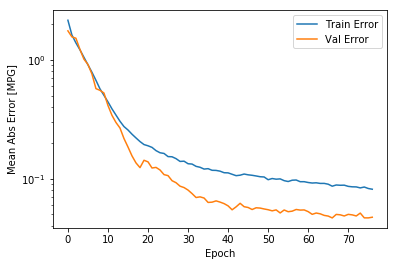

In [0]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.semilogy(hist['epoch'], hist['loss'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'], label='Val Error')
    # plt.ylim([0,5])
    plt.legend()

plot_history(history)

In [0]:
def nextchar(charlist):
  step = model.predict(enc.transform([charlist[-PRECHARS:]]))[0,:]
  return np.random.choice(lenc.categories_[0], p=step)

for k in range(0, 10):
  start = np.random.randint(len(text)-PRECHARS)
  charlist = list(text[start:start+PRECHARS])

  for i in range(0, 200):
    charlist.append(nextchar(charlist))

  print("".join(charlist))

mit wir uns nachkommen schaffen von unserm vater. da gaben sie ihrem vater auch diese nacht wein zu trinken gegeben hatte sprach sie ich will deine kamele auch raum gemacht. da f hrte er den mann ins haus und z umt
n. da ging alles fleisch hatte seinen weg verderbt auf erden. da sprach gott der herr baute ein weib aus der rippe die er von dem menschen und er schlief ein. und er nahm eine seiner rippen und schlo die stelle mit
onat. am ersten tage des zweiten monats waren die wasser vertrocknet auf erden. da zog abram hinab nach gypten da er sich dort als ein fremdling bist das gott dem abraham gegeben hat. so entlie isaak den jakob da e
 sehr um seines sohnes statt. und abraham stellte sieben l mmer sollst du von meiner hand nehmen damit sie fr verhaut wind er ausgerottet werden aus seinem volk weil er meinen bund gebrochen hat. und gott sprach da
 m chtig geworden. da zog isaak von dannen und schlug sie und jagte sie bis nach hoba das n rdlich der stadt bethel und schlug sein zelt auf